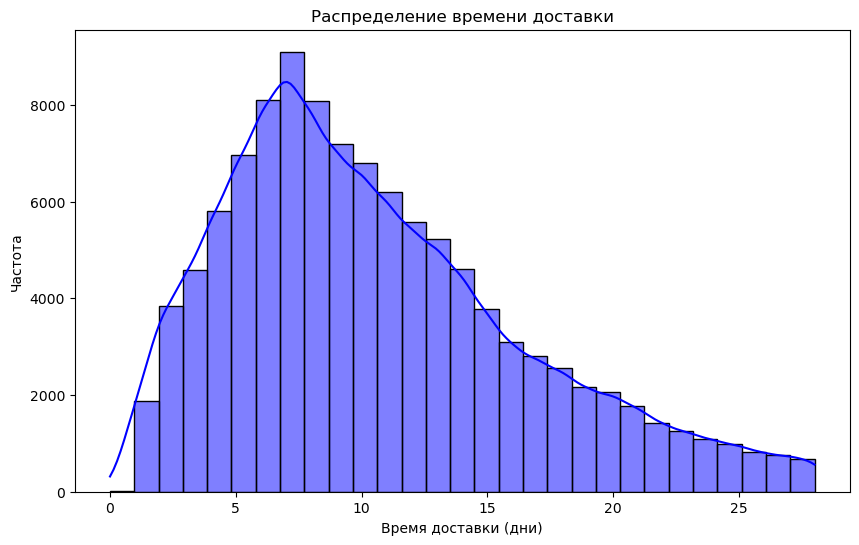

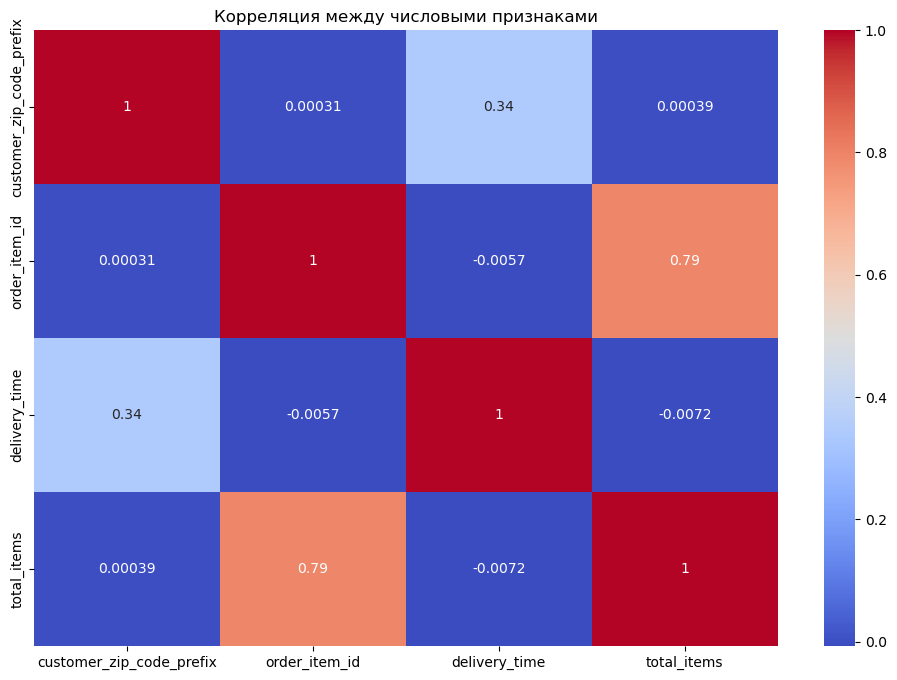

Mean Squared Error (Linear Regression): 28.334509651223858
Mean Squared Error (kNN): 30.5897171624714


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error 

# Загрузка данных
customers = pd.read_csv("./datasets/olist_customers_dataset.csv")
orders = pd.read_csv("./datasets/olist_orders_dataset.csv")
order_items = pd.read_csv("./datasets/olist_order_items_dataset.csv")
order_payments = pd.read_csv("./datasets/olist_order_payments_dataset.csv")

# Объединение данных
data = pd.merge(orders, customers, on='customer_id')
data = pd.merge(data, order_items[['order_id', 'order_item_id']], on='order_id')
data = pd.merge(data, order_payments[['order_id', 'payment_type']], on='order_id')

# Удаление ненужных столбцов
data.drop(['order_approved_at', 'order_delivered_carrier_date', 'order_estimated_delivery_date'], axis=1, inplace=True)

# Преобразование дат в формат datetime(нужный формат)
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
data['order_delivered_customer_date'] = pd.to_datetime(data['order_delivered_customer_date'])

# Расчет времени доставки
data['delivery_time'] = (data['order_delivered_customer_date'] - data['order_purchase_timestamp']).dt.days

# Обработка выбросов (аномалий) во времени доставки
Q1 = data['delivery_time'].quantile(0.25)
Q3 = data['delivery_time'].quantile(0.75)
IQR = Q3 - Q1
# удаляем выбросы и нормализуем данные
data = data[(data['delivery_time'] >= (Q1 - 1.5 * IQR)) & (data['delivery_time'] <= (Q3 + 1.5 * IQR))]

# Обработка пропущенных значений
data.dropna(inplace=True)

# Обработка нескольких заказов одного клиента
total_items = order_items.groupby('order_id').size().reset_index(name='total_items')
data = pd.merge(data, total_items, on='order_id')

# Исследование распределения времени доставки
plt.figure(figsize=(10, 6))
sns.histplot(data['delivery_time'], bins=len(data['delivery_time'].value_counts()), kde=True, color='blue')
plt.title('Распределение времени доставки')
plt.xlabel('Время доставки (дни)')
plt.ylabel('Частота')
plt.show()

# Кодирование категориального признака 'customer_state'
data = pd.get_dummies(data, columns=['customer_state'])

# Исследование корреляции между признаками
numeric_columns = data.select_dtypes(include=['number']).columns
plt.figure(figsize=(12, 8))
sns.heatmap(data[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Корреляция между числовыми признаками')
plt.show()

# Подготовка данных для модели
X = data[['customer_zip_code_prefix', 'total_items'] + [col for col in data.columns if col.startswith('customer_city_')] + [col for col in data.columns if col.startswith('customer_state_')]]
y = data['delivery_time']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Масштабирование признаков
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Обучение и оценка модели линейной регрессии
model_lr = LinearRegression()
model_lr.fit(X_train_scaled, y_train)
y_pred_lr = model_lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print("Mean Squared Error (Linear Regression):", mse_lr)

# Обучение и оценка модели kNN
model_knn = KNeighborsRegressor(n_neighbors=5)
model_knn.fit(X_train_scaled, y_train)
y_pred_knn = model_knn.predict(X_test_scaled)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print("Mean Squared Error (kNN):", mse_knn)


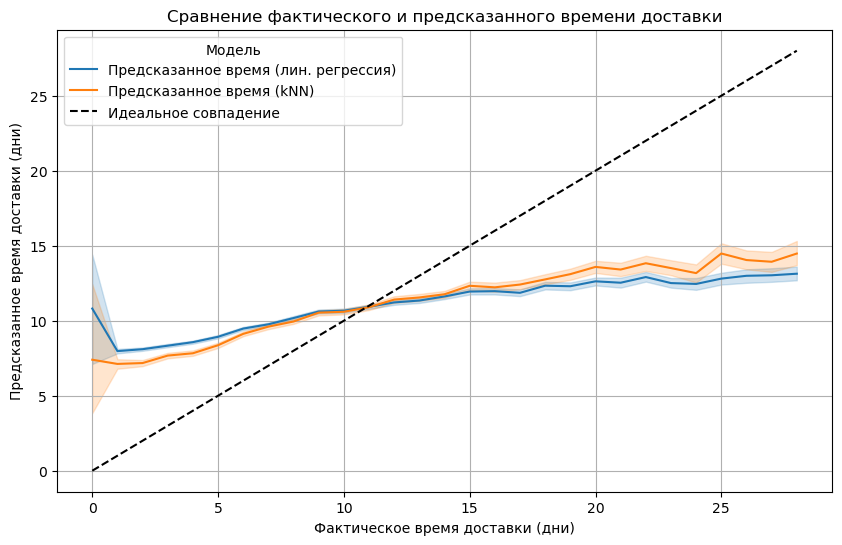

In [2]:
# Объединяем фактическое и предсказанное время доставки в один DataFrame
results = pd.DataFrame({'Фактическое время': y_test, 'Предсказанное время (лин. регрессия)': y_pred_lr, 'Предсказанное время (kNN)': y_pred_knn})

# Преобразуем данные в "длинный" формат для использования с Seaborn
results = results.melt(id_vars=['Фактическое время'], var_name='Модель', value_name='Время доставки')

# Строим график с помощью Seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='Фактическое время', y='Время доставки', hue='Модель', data=results)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--k', label='Идеальное совпадение')
plt.title('Сравнение фактического и предсказанного времени доставки')
plt.xlabel('Фактическое время доставки (дни)')
plt.ylabel('Предсказанное время доставки (дни)')
plt.legend(title='Модель')
plt.grid(True)
plt.show()


In [3]:
from sklearn.metrics import mean_absolute_error, r2_score

# Оценка точности модели линейной регрессии
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)

print("Модель линейной регрессии:")
print("Средняя абсолютная ошибка (MAE):", mae_lr)
print("Коэффициент детерминации (R-squared):", r2_lr)
print("Среднеквадратичная ошибка (RMSE):", rmse_lr)
print()

# Оценка точности модели kNN
mae_knn = mean_absolute_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)
rmse_knn = mean_squared_error(y_test, y_pred_knn, squared=False)

print("Модель kNN:")
print("Средняя абсолютная ошибка (MAE):", mae_knn)
print("Коэффициент детерминации (R-squared):", r2_knn)
print("Среднеквадратичная ошибка (RMSE):", rmse_knn)


Модель линейной регрессии:
Средняя абсолютная ошибка (MAE): 4.185783707920452
Коэффициент детерминации (R-squared): 0.22675727794384615
Среднеквадратичная ошибка (RMSE): 5.323016968902491

Модель kNN:
Средняя абсолютная ошибка (MAE): 4.243011441647597
Коэффициент детерминации (R-squared): 0.16521314620259997
Среднеквадратичная ошибка (RMSE): 5.5307971543414425


In [4]:
from sklearn.model_selection import GridSearchCV

# Определение диапазона гиперпараметров для модели линейной регрессии
param_grid_lr = {'fit_intercept': [True, False]}

# Определение диапазона гиперпараметров для модели kNN
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11]}

# Настройка модели линейной регрессии с использованием GridSearchCV
grid_search_lr = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid_lr, scoring='neg_mean_squared_error', cv=5)
grid_search_lr.fit(X_train_scaled, y_train)
best_params_lr = grid_search_lr.best_params_
best_model_lr = grid_search_lr.best_estimator_

# Настройка модели kNN с использованием GridSearchCV
grid_search_knn = GridSearchCV(estimator=KNeighborsRegressor(), param_grid=param_grid_knn, scoring='neg_mean_squared_error', cv=5)
grid_search_knn.fit(X_train_scaled, y_train)
best_params_knn = grid_search_knn.best_params_
best_model_knn = grid_search_knn.best_estimator_

# Оценка результатов моделей
y_pred_lr = best_model_lr.predict(X_test_scaled)
mse_lr = mean_squared_error(y_test, y_pred_lr)
print("Linear Regression Best Parameters:", best_params_lr)
print("Mean Squared Error (Linear Regression):", mse_lr)

y_pred_knn = best_model_knn.predict(X_test_scaled)
mse_knn = mean_squared_error(y_test, y_pred_knn)
print("kNN Best Parameters:", best_params_knn)
print("Mean Squared Error (kNN):", mse_knn)

Linear Regression Best Parameters: {'fit_intercept': True}
Mean Squared Error (Linear Regression): 28.334509651223858
kNN Best Parameters: {'n_neighbors': 11}
Mean Squared Error (kNN): 28.77597291828205


Mean Squared Error: 186504357.9376973
R^2 Score: 0.2637078304465639


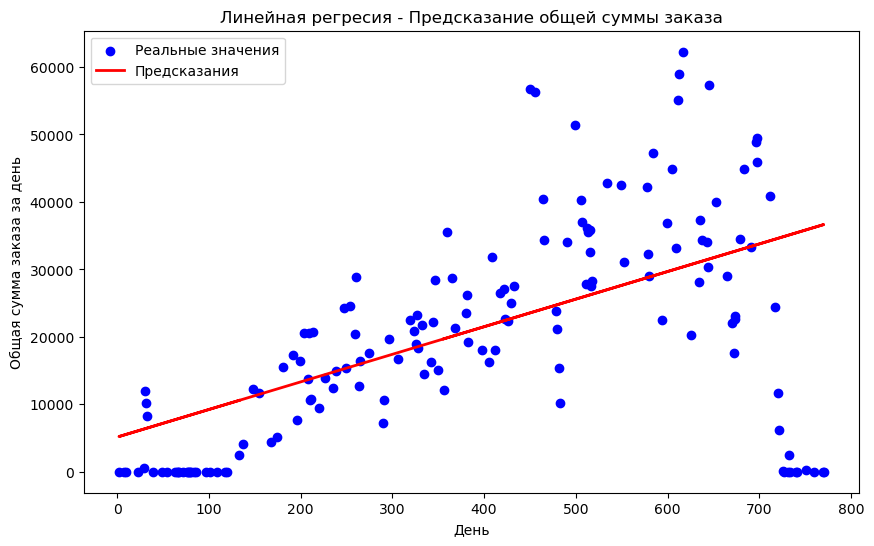

In [7]:
# Загрузка данных о заказах
orders = pd.read_csv('datasets/olist_orders_dataset.csv')

# Преобразование столбца даты в формат datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Загрузка данных о платежах
order_payments = pd.read_csv('datasets/olist_order_payments_dataset.csv')

# Объединение данных о заказах и платежах
order_data = pd.merge(orders, order_payments, on='order_id')

# Установка столбца с датой заказа в качестве индекса
order_data.set_index('order_purchase_timestamp', inplace=True)

# Группировка данных по дням и суммирование общей суммы заказа
daily_revenue = order_data.resample('D')['payment_value'].sum().reset_index()

# Создание признаков: номер дня и общая сумма заказа
daily_revenue['day_number'] = (daily_revenue['order_purchase_timestamp'] - daily_revenue['order_purchase_timestamp'].min()).dt.days
X = daily_revenue[['day_number']]
y = daily_revenue['payment_value']

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели линейной регрессии
model = LinearRegression()
model.fit(X_train, y_train)

# Прогнозирование на тестовом наборе
y_pred = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Mean Squared Error:', mse)
print('R^2 Score:', r2)

# Визуализация результатов
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', label='Реальные значения')
plt.plot(X_test, y_pred, color='red', linewidth=2, label='Предсказания')
plt.title('Линейная регресия - Предсказание общей суммы заказа')
plt.xlabel('День')
plt.ylabel('Общая сумма заказа за день')
plt.legend()
plt.show()

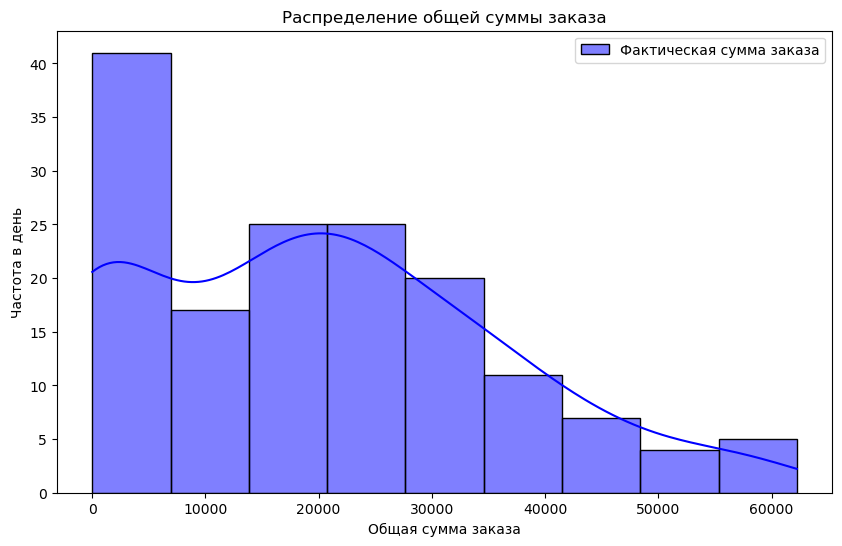

In [8]:
# Гистограмма общей суммы заказа с кривой распределения
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Фактическая сумма заказа')
plt.xlabel('Общая сумма заказа')
plt.ylabel('Частота в день')
plt.title('Распределение общей суммы заказа')
plt.legend(loc='upper right')
plt.show()